# Steve Chadwick

## Midterm Project

In [1]:
#!conda install -y mkl-service

In [2]:
import os
os.environ['MKL_THREADING_LAYER'] = 'GNU'

import pymc3 as pm
import numpy as np
import scipy as sc
from matplotlib import pyplot as plt
from datetime import datetime

Here we import the Global Temperature csv file and convert the dates from strings into dates.

In [3]:
with open('./GlobalTemperatures.csv', 'r') as inp:
    inp.readline()
str2date = lambda x: datetime.strptime(x.decode("utf-8"), '%Y-%m-%d')
data = np.genfromtxt('./GlobalTemperatures.csv', dtype=None, names=True, delimiter=',', converters={0:str2date})

Here we just plot all of the data as a scatter plot to see how noisy it is and the trends.

Text(0,0.5,'average global temperature ($^\\circ$C)')

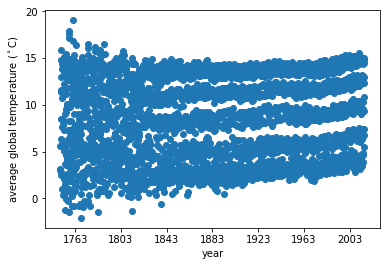

In [4]:
plt.scatter(data['dt'], data['LandAverageTemperature'])
plt.xlabel('year')
plt.ylabel('average global temperature ($^\circ$C)')

The data is quite noisy in the first 100 years so we'll only select temperatures after that point. We also can see that the temperatures seem to form bands, we can infer that these are corrolated to seasons so to narrow our data down we'll just pick one month. The following code picks out all the values in the sixth month of each year after 1850. Then we define our years and temperatures.

In [5]:
sel = np.zeros(len(data), dtype='bool')
for i, date in enumerate(data['dt']):
    if date.year > 1850 and date.month == 6: # adds data points after 1850 in June.
        sel[i] = True

years = np.array([date.year for date in data[sel]['dt']]) # defines our years
temps = data[sel]['LandAverageTemperature'] # defines our average temperatures

Here we plot the data with guesses at how linear fits might look for the data with one switch point. This is just for refrence since estimating a y intercept is difficult without a plot.

Text(0,0.5,'Average Golobal Temperature ($^\\circ$C)')

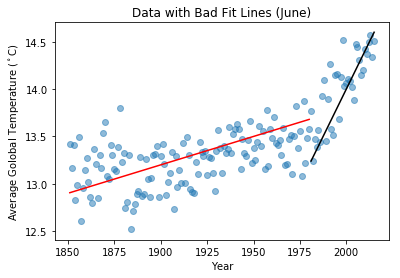

In [56]:
years1 = years[:130] # here we guess that the switch point is at 1980 and select the years before this point
years2 = years[130:] # This takes a list of all the years after 1980

bad_fit1 = .006*years1 + 1.8 # by guess and check I was able to find these values and get a feel for the slope and y intercept
bad_fit2 = .04*years2 - 66

plt.scatter(years, temps, alpha= .5)
plt.plot(years1,bad_fit1, color='r')
plt.plot(years2, bad_fit2, color='k')
plt.title('Data with Bad Fit Lines (June)')
plt.xlabel('Year')
plt.ylabel('Average Golobal Temperature ($^\circ$C)')

# Single Line

Now that we have a feel for the data we want to try to find a basic line of best fit for the data. The data doesn't look linear but this will help us explore pymc3's model generators.

We start with a line model. We define our prior with large standard deviations so that we don't bias our posterior and we set the average value in the Normal distributions based on where the intercept might be and what the slope might be. This is where it was helpful to do the bad fits above. The standard deviation for the prior sigma 10 since we expect a value close to zero but don't want to constrain the model too much. We expect a y intercept around 0 but want to let the model explore values +/- 100 degrees, since we really don't know. We also expect x to be less than one but positive but we'll leave the prior standard deviation at 10 so that the model finds the values and isn't infulenced by our expectations.

In [74]:
with pm.Model() as line_model: # model specifications in PyMC3 are wrapped in a with-statement
    # Define priors
    sigma = pm.HalfNormal('sigma', sd=10)
    intercept = pm.Normal('Intercept', 0, sd=100)
    x_coeff = pm.Normal('x', .01, sd=10)
    
    # Expected value of outcome
    mu = x_coeff*years + intercept

    # likelihood
    likelihood = pm.Normal('temp', mu=mu, sd=sigma, observed=temps)
    
    # Use NUTS to sample our distributions.
    trace1 = pm.sample(3000, cores=2) # draw 3000 posterior samples using NUTS sampling

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [x, Intercept, sigma]
Sampling 2 chains: 100%|██████████| 7000/7000 [01:24<00:00, 82.45draws/s] 


Now, we plot the trace plots and analyize our outcomes. These look really good because our graphs indicate our chains were very noisy and our confidence levels in all of our parameters are much lower than our given standard deviations. We can see that the Intercept is about 0.5 with a standard deviation of about 3, our given standard deviation was 100, so we can assume the data provided us with a good confidence level. Similar shrinkages in standard deviations are also true for the x coefficent and the sigma values; both have standard deviations far below the give standard deviation of 10.

<Figure size 504x504 with 0 Axes>

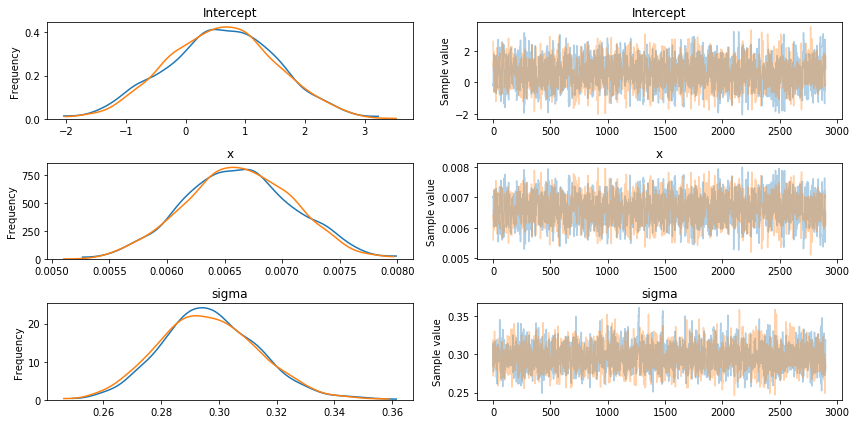

In [8]:
plt.figure(figsize=(7, 7))
pm.traceplot(trace1[100:]) # here we chop off any burnin
plt.tight_layout();

Next, we'll plot our best fit lines, here we'll use plot_posterior_predictive_gml to give a feel for the uncertainty about our best fit line. As you can see the regresion lines are somewhat spread out, which indicates that our best fit lines aren't perfect. Our sigma value, which averaged around .29 also indicates that we have room for improvement.

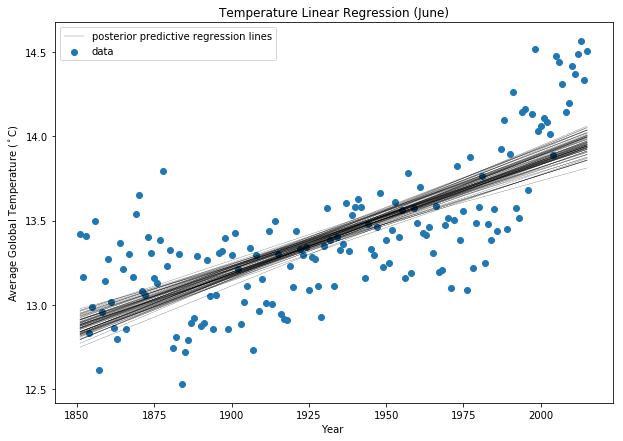

In [57]:
plt.figure(figsize=(10, 7))
plt.scatter(years, temps, label='data')
pm.plot_posterior_predictive_glm(trace1, eval=years, samples=80,
                              label='posterior predictive regression lines')

plt.title('Temperature Linear Regression (June)')
plt.legend(loc=0)
plt.xlabel('Year ')
plt.ylabel('Average Golobal Temperature ($^\circ$C)');

# Switch Point

Now, we'll utilize the switch point function to create two best fit lines. We'll use a discrete uniform distribution for our switchpoint since out years are discrete values and a Half Cauchy for our sigma value since this is slightly more inclusive than a half normal. For our other distribtutions we'll use Normal distribution, since we have no reason to expect our data to behave like any other specific distributions.

Again, we'll also choose large standard deviations to avoid influencing the outcomes. We'll also try to pick large enough standard deviations such that we don't have to check parameter spaces that are too big as this will slow down our traces. 

All of these parameters are in terms of "early" and "late" elements, the "early" elements all relate to the values before the switchpoint and the "late" elements all relate to the elements after the switch point. This type of labeling will be consistent throughout this project.

In [10]:
with pm.Model() as switch_model:
    
    # Priors
    switchpoint = pm.DiscreteUniform('switchpoint', lower=years.min(), upper=years.max(), testval=1975)
    
    early_sigma = pm.HalfCauchy('early_sigma', 10) # we'll only use one choice of sigma for now to simplify things.
    early_intercept = pm.Normal('early_Intercept', 0, sd=100, testval=0)
    early_x_coeff = pm.Normal('early_x', .01, sd=20, testval = .1)
    
    late_intercept = pm.Normal('late_Intercept', -80, sd=100, testval=-80)
    late_x_coeff = pm.Normal('late_x', .05, sd=20, testval=.1)
    
    # Expected values of outcome
    early_mu = early_x_coeff*years + early_intercept # Early line.
    late_mu = late_x_coeff*years + late_intercept # Late line.

    mu = pm.math.switch(switchpoint >= years, early_mu, late_mu) # this will switch between the first line and second line after the switch year.
    
    # Likelihood
    temps1 = pm.Normal('temps1', mu, sd=early_sigma,observed=temps)

In [11]:
with switch_model:
    trace2 = pm.sample(3000) # Draw 3000 posterior samples using Metropolis algorithm

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [switchpoint]
>NUTS: [late_x, late_Intercept, early_x, early_Intercept, early_sigma]
Sampling 2 chains: 100%|██████████| 7000/7000 [08:51<00:00, 13.17draws/s]
The acceptance probability does not match the target. It is 0.916191799269, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


Examining the traceplot helps us see the results of our model. Once again, all of our standard deviations are much smaller than the ones we provided and our confidence levels seem fair. The graphs on the left convay that our chains worked well, they all have lots of noise and don't seem to trend in any specific way. This indicates we had good step sizes in our chains and that our priors weren't constricting our search.

While our switchpoint doesn't offer quite as much confidence about the year as our other parameters it still looks good enough. This begs the question are there other switch points in the data that might've contributed to the uncertainty. Other switchpoints would make sense since the global temperature is affected by so many different factors.

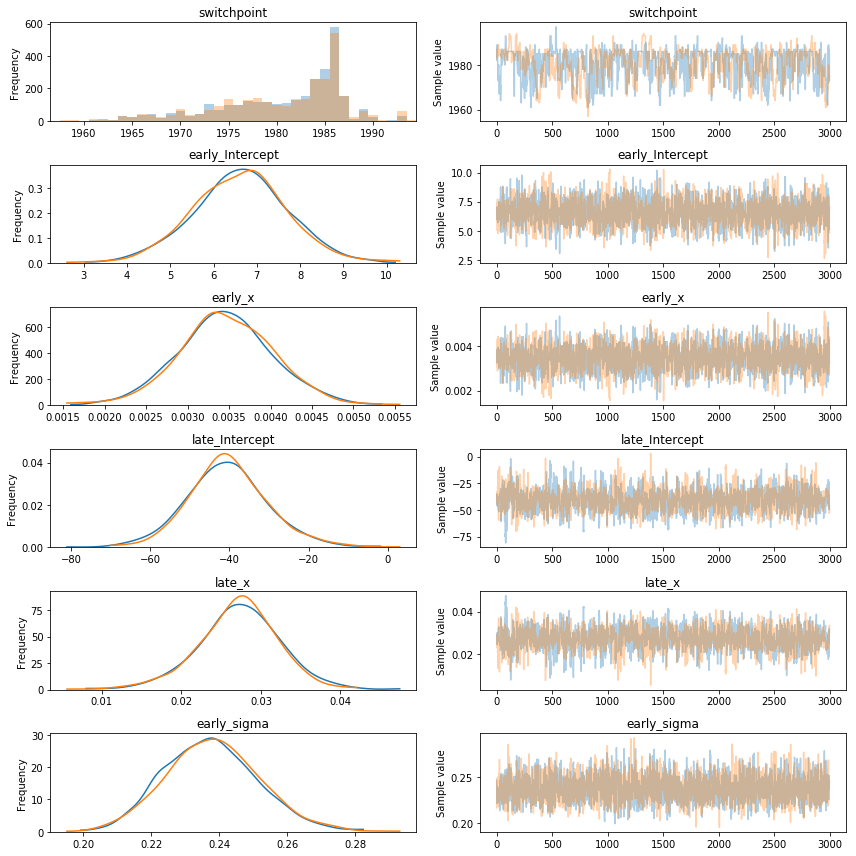

In [12]:
pm.traceplot(trace2);

Now, we'll plot our data with the different lines before and after the switchpoint. This is helpful to determine if our model did a good job or not. Since both lines seem to trend with the data fairly well there are no obvious red flags about our model and we can proceed. We can also notice that there is a break in the line at our switch point. This is probably not a realistic interpretation of how the temperature changed and we can assume a more smooth transition from the early slope to late slope during the green section of time (the highest posterior density).

We'll also notice that the highest posterior density (the area which has a 95% confidence level of containing the switchpoint) is relitively narrow, which is a good indicator that our switchpoint is accurate.

In addition, we can see that without constiriction our priors we were able to return linear regression lines that reflect our intution (demonstrated by the initial "bad_fit" graph)

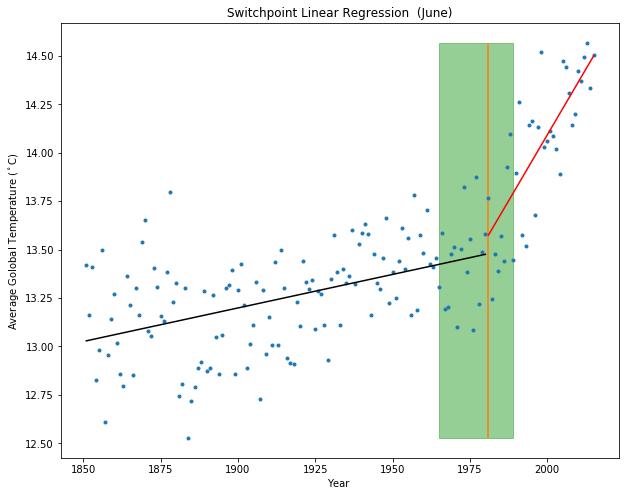

In [66]:
plt.figure(figsize=(10, 8))
plt.plot(years, temps, '.')
plt.xlabel('Year ')
plt.ylabel('Average Golobal Temperature ($^\circ$C)')

plt.vlines(trace2['switchpoint'].mean(), temps.min(), temps.max(), color='C1') # draws a line at the average switchpoint

# Plots the highest posterior density in green
sp_hpd = pm.hpd(trace2['switchpoint'])
plt.fill_betweenx(y=[temps.min(), temps.max()],
                  x1=sp_hpd[0], x2=sp_hpd[1], alpha=0.5, color='C2');

early_years = years[:len(years)-(1+years[-1]-int(round(trace2['switchpoint'].mean())))] # years before switch point
late_years = years[len(years)-(1+years[-1]-int(round(trace2['switchpoint'].mean()))):] # years after switch point

early_line = early_years*trace2['early_x'].mean() + trace2['early_Intercept'].mean() # function for line based on average computed early values

late_line = late_years*trace2['late_x'].mean() + trace2['late_Intercept'].mean() # function for line based on average computed late values

plt.title('Switchpoint Linear Regression  (June)')
plt.plot(early_years, early_line, color='k') # plot for early line
plt.plot(late_years, late_line, color='r'); # plot for late line

The gelman_rubin results of this model are pretty good since r_hat is below 1.001 for all values except the switchpoint, which is very close to 1.001. We can also see from the auto correlation plot that the decay is very quick for everything except the switch point, but that decay isn't too slow either. Lastly, we can see that our effective samples are in the thousands range for everything except the switch point. Higher numbers for all of these would be ideal and with more time we could use a higher sample rate but for now these will work.

In [14]:
pm.gelman_rubin(trace2)

{'switchpoint': 1.0001778975992188,
 'early_Intercept': 1.0000303873248948,
 'early_x': 1.0000346798074573,
 'late_Intercept': 1.0009314065752941,
 'late_x': 1.0009346399973005,
 'early_sigma': 1.0009930302581007}

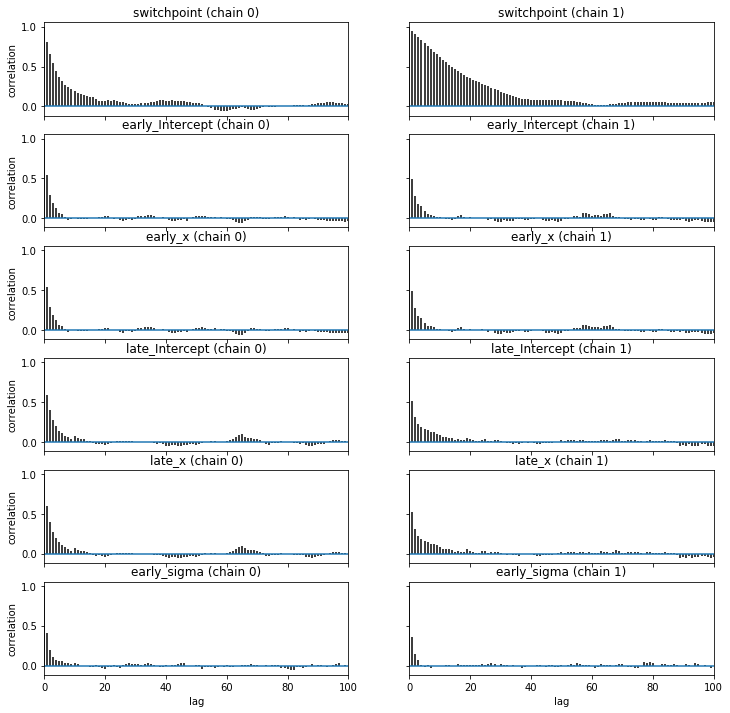

In [15]:
pm.autocorrplot(trace2);

In [16]:
pm.effective_n(trace2)

{'switchpoint': 231.13289275414778,
 'early_Intercept': 1675.5304967968909,
 'early_x': 1672.2291369758323,
 'late_Intercept': 1108.0677535005236,
 'late_x': 1111.4653997810328,
 'early_sigma': 2301.1167963692878}

Overall, the switch point seems like our best guess for a single point and we will proceed by assuming it has a reasonable degree of correctness.

# Switch Point Sigmas

Now, we want to use the switchpoint we found earlier to find new linear regression values. This way, we can find  a sigma value specific to the early and late regression lines. This won't be completely accurate since the sigma values for each line probably rely on all the data and not just the data in that section but the hope is that this will improve our sigma for the late years since in the previous model only the sigma for the early years was used/computed.

Since the previous simulation we used the sigma value from the early line to influence both our lines now we can see if the the sigma value is different for each line, which we would expect.

In [17]:
switch_year = int(round(trace2['switchpoint'].mean())) # defines the year of the switchpoint.
switch_year

1981

This code just breaks up our temperatures and years into the groups before and after the switchpoint.

In [18]:
early_years = years[:len(years)-(1+years[-1]-int(round(trace2['switchpoint'].mean())))] # years before switch point
late_years = years[len(years)-(1+years[-1]-int(round(trace2['switchpoint'].mean()))):] # years after switch point

early_temps = temps[:len(years)-(1+years[-1]-int(round(trace2['switchpoint'].mean())))] # temps before switch point
late_temps = temps[len(years)-(1+years[-1]-int(round(trace2['switchpoint'].mean()))):] # temps after switch point

Now we create a new model using only the data before the switch point. This will return a sigma specific to the early line we generate. We dont expect the data from before the switch point to be independent of the data after the switch point but splitting up the two sections will help us visualize two different lines and will also help us generate data later. We'll use the same linear fit as before but with just the late years.

Once again we choose priors with standard deviations such that we won't constrain our results but don't have to search over a huge parameter space. Again we choose values roughly an order of magnitude or two above our expected value.

In [73]:
with pm.Model() as early_sigma_model:
    
    # Priors:
    early_sigma = pm.HalfCauchy('early_sigma', 10)
    early_intercept = pm.Normal('Intercept', -50, sd=80)
    early_x = pm.Normal('x', .01, sd=1)
    
    # Expected value of outcome
    early_mu = early_x*early_years + early_intercept
    
    # Likelihood
    likelihood = pm.Normal('likelihood', early_mu, sd=early_sigma ,observed=early_temps)

In [20]:
with early_sigma_model:
    trace3 = pm.sample(3000) # Draw 3000 posterior samples using NUTS algorithm

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [x, Intercept, early_sigma]
Sampling 2 chains: 100%|██████████| 7000/7000 [04:04<00:00, 28.59draws/s]
The acceptance probability does not match the target. It is 0.9907753694, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.990393122383, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


Once again we have fairly healthy looking chains and confidence levels that reflect good searches. All the standard deviations are much smaller than those of our priors, which implies the MCMC process wasn't heavily influenced by our priors.

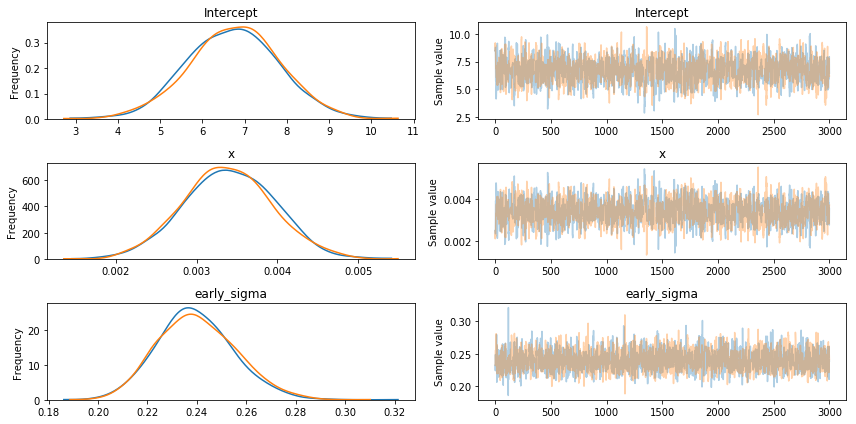

In [21]:
pm.traceplot(trace3);

Now we'll create a new model based on the data after the switch point. We dont have as much data here so we can't expect as strong confidence as the early sigma model, but we should have enough to find a reasonable best fit line with a good sigma. We'll use the same linear fit as before but with just the late years. We'll also make decisions about priors based on the same logic as previously described. We'll pick a mean value of -50 for our late intercept since our previous simulations demonstrate that this is a good starting place but our standard deviation of 80 should allow this to explore lots of other possible values.

In [72]:
with pm.Model() as late_sigma_model:
    
    # Priors:
    late_sigma = pm.HalfCauchy('late_sigma', 5)
    late_intercept = pm.Normal('Intercept', -50, sd=80)
    late_x = pm.Normal('x', .01, sd=10)
    
    # Expected value of outcome
    late_mu = late_x*late_years + late_intercept
    
    # Likelihood:
    likelihood = pm.Normal('likelihood', late_mu, sd=late_sigma ,observed=late_temps)

In [23]:
with late_sigma_model:
    trace4 = pm.sample(3000) # Draw 3000 posterior samples using NUTS algorithm

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [x, Intercept, late_sigma]
Sampling 2 chains: 100%|██████████| 7000/7000 [05:19<00:00, 21.92draws/s]
There were 31 divergences after tuning. Increase `target_accept` or reparameterize.
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


As expected our confidence levels aren't as strong as previous simulations, but this is because our data set is smaller. Fortunately we'll be able to check that our values look reasonable when we plot the linear regression lines from trace 3 and trace 4 together. We'll also notice that our late sigma value looks to be lower than our early sigma value. This makes sense since the data looks noisier before the switch point.

We can also see that our chains look good, none of them seem to have trends and they all are quite noisy.

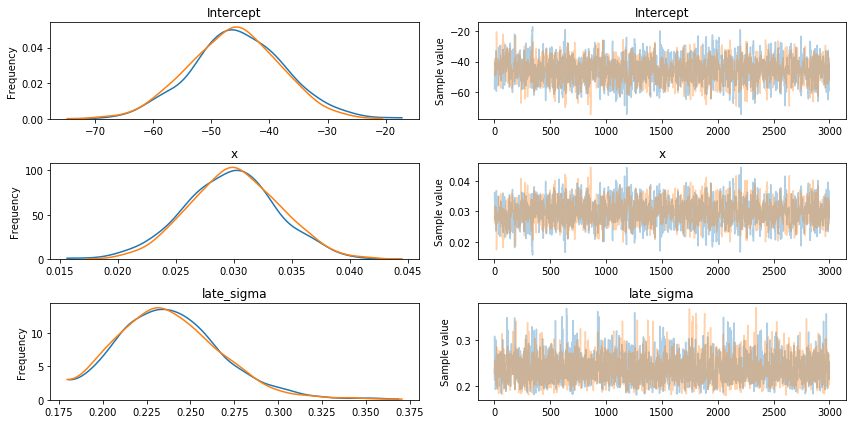

In [24]:
pm.traceplot(trace4);

This graph reveals how our smaller data set for the late year results in a lower confidence levels. The red lines are more spread than the black lines indicating that more samples varied from one another. This is okay though, we expected this given the smaller data set for the late years and we were really just looking to see how the late sigma compared to the early sigma. This graph also give us a better indication that the two lines aren't disjoint (which the previous graph implied) since there are a number of sample lines that look like they could connect. 

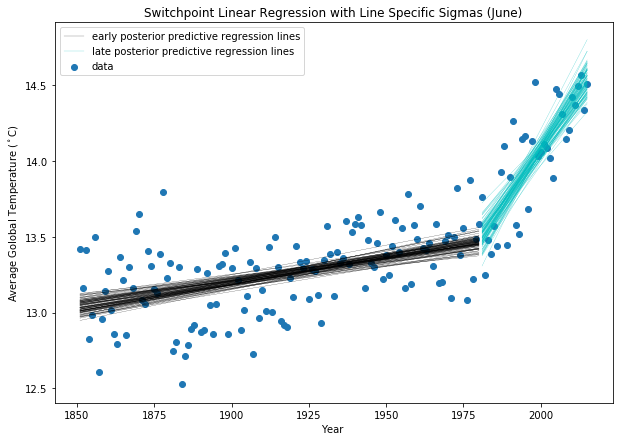

In [67]:
plt.figure(figsize=(10, 7))
plt.scatter(years, temps, label='data')

pm.plot_posterior_predictive_glm(trace3, eval=early_years, samples=100,
                              label='early posterior predictive regression lines')

pm.plot_posterior_predictive_glm(trace4, eval=late_years, samples=100,
                              label='late posterior predictive regression lines', color='c')

plt.title('Switchpoint Linear Regression with Line Specific Sigmas (June)')
plt.legend(loc=0)
plt.xlabel('Year ')
plt.ylabel('Average Golobal Temperature ($^\circ$C)');

Looking at our gelman rubin statistics for both trace3 and trace4 we can see that our r_hat values for the early years are quite good (below 1.001) and our late years aren't quite as good (slightly above 1.001 except for the late sigma value). These values are close enough though and will work for this model. We also see good autocorrelation graphs with quick decays to zero. Lastly we'll notice our effective sample size is in the thousands range which is ideal for all values.

In [26]:
pm.gelman_rubin(trace3)

{'Intercept': 1.0004027182524142,
 'x': 1.0004118821561874,
 'early_sigma': 1.0003888534861149}

{'Intercept': 1431.2509830940428,
 'x': 1431.7404881800817,
 'early_sigma': 1852.10891199761}

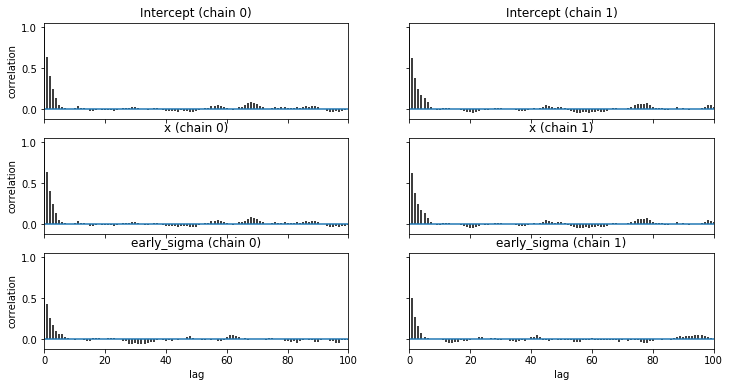

In [27]:
pm.autocorrplot(trace3)
pm.effective_n(trace3)

In [28]:
pm.gelman_rubin(trace4)

{'Intercept': 1.0031628302482336,
 'x': 1.0031683877504709,
 'late_sigma': 1.0003632550156498}

{'Intercept': 1257.5304600593581,
 'x': 1256.351636145549,
 'late_sigma': 2172.0289823218718}

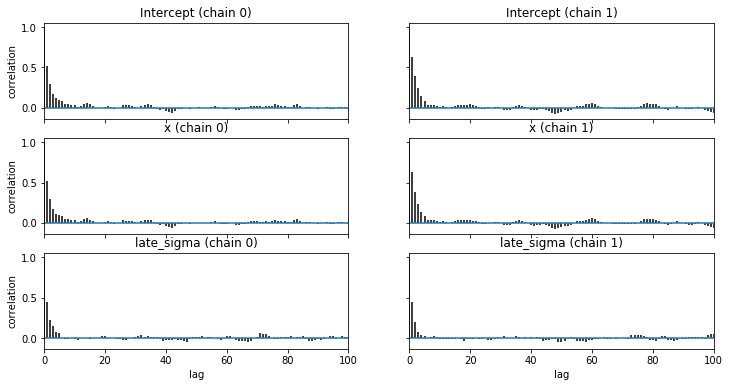

In [29]:
pm.autocorrplot(trace4)
pm.effective_n(trace4)

# Data Generation

Now that we have several models for the data we'll generate our own and compare it with the actual data. The first graph shows data generated with the switchpoint model using just the early sigma value. The second graph shows data generated the switchpoint model and a sigma value for each slope.

In [ ]:
"""This function generates linear data with noise defined by a given sigma parameter. M is the slope, xs are
the data from the x axis, b is the y intercept and sigma is the noise parameter. The noise will be modeled with
a normal distribution using np.random.normal."""

def linear_data_generatation(m, xs, b, sigma):
    y = m*xs + b + np.random.normal(scale=sigma, size=len(xs))
    return y

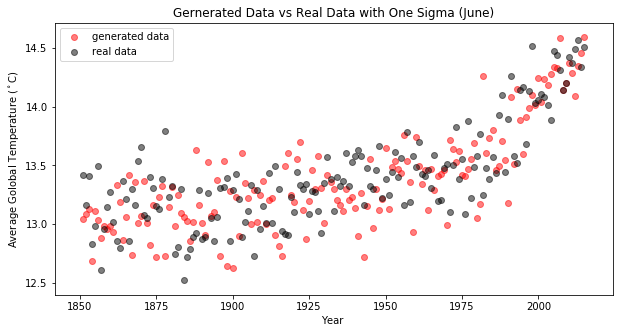

In [71]:
early_data = linear_data_generatation(trace2['early_x'].mean(), early_years, trace2['early_Intercept'].mean(), trace2['early_sigma'].mean())

late_data = linear_data_generatation(trace2['late_x'].mean(), late_years, trace2['late_Intercept'].mean(), trace2['early_sigma'].mean())

plt.figure(figsize=(10, 5))
plt.scatter(early_years, early_data, color = 'r', label='generated data', alpha=.5)
plt.scatter(late_years, late_data, color = 'r', alpha=.5)
plt.scatter(years, temps, color='k', label='real data', alpha=.5)
plt.title('Gernerated Data vs Real Data with One Sigma (June)')
plt.legend(loc=0)
plt.xlabel('Year ')
plt.ylabel('Average Golobal Temperature ($^\circ$C)');

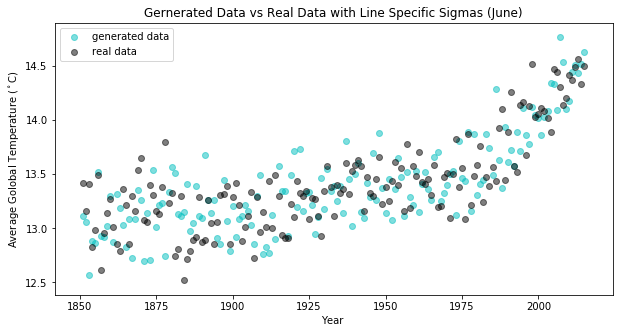

In [70]:
early_data = linear_data_generatation(trace3['x'].mean(), early_years, trace3['Intercept'].mean(), trace3['early_sigma'].mean())

late_data = linear_data_generatation(trace4['x'].mean(), late_years, trace4['Intercept'].mean(), trace4['late_sigma'].mean())

plt.figure(figsize=(10, 5))
plt.scatter(early_years, early_data, color = 'c', label='generated data', alpha=.5)
plt.scatter(late_years, late_data, color = 'c', alpha=.5)
plt.scatter(years, temps, color='k', label='real data', alpha=.5)
plt.title('Gernerated Data vs Real Data with Line Specific Sigmas (June)')
plt.legend(loc=0)
plt.xlabel('Year ')
plt.ylabel('Average Golobal Temperature ($^\circ$C)');

After examining the generated data it's difficult to say if the change in sigma values made much of a difference. Both models seem to generate data that closely resembels our initial data set. The graph with line specific sigma values seems to be slightly less noisy but this is in no way conclusive when comparing the two models. Overall the switchpoint function seemed to work well when preforming linear regession and seems to have found a good year for the switch. A year around 1980 also makes sense if we think global population effects global average temperatures. Since the global population nearly doubled between 1980 and 2015 the increase in population could definitely have influenced the global average temperature. Increased CO2 emissions are strongly connected to humans and more humans would imply more CO2 emissions. Although it should be noted that these thoughts about causation are largly based on the work of other people and general knowledge about physics and not necessarily demonstrated by our models here.

If this project were continued beyond linear regression we could expect to find a single nonlinear line that would model this data with a non-peicewise funtion. Another aspect we would want to add is a sigma value dependent on time, from the looks of the data and what we know about improvements in measurments we would want to check to see if the data was less noisy later in time and model that. While these changes could prove to model the data more exactly, for our purposes the linear regression we have is saticfactory.